In [5]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]
#Changes to these correlations over 61 days
change = []
k_0 = 0.003
for i in range (0, 61):
    change.append(np.sin(k_0*i))    

In [6]:
sigma = 0.6
#Correlation matrix of 100 stocks based on their sector structure
daily_corr = np.zeros((61, 100, 100))
for (i, j) in product (range(0,100), range(0,100)):
    for k in range(0, 61):
        if (i>j):
            daily_corr[k][i][j] = np.tanh(np.random.normal(M2_S[i/10, j/10]+change[k], sigma, 1))
            daily_corr[k][j][i] = daily_corr[k][i][j]
        else:
            if (i==j):
                daily_corr[k][i][j] = 1.0

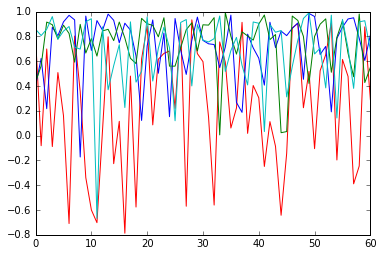

In [7]:
#Plots showing evolution of the correlations between some stocks
a,b,c,d = [],[],[],[]
for i in range (0,61):
    a.append(daily_corr[i][9][94])
    b.append(daily_corr[i][97][95])
    c.append(daily_corr[i][10][11])
    d.append(daily_corr[i][10][12])

plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
plt.show()

In [8]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples):
    mu = np.zeros(100)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns

In [9]:
#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples):
    r0, r1 = return_generator(N_samples)
    model1 = []
    model2 = np.zeros((N_samples, 100, 100))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,10), range(0,10)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for (i,j) in product(range(0,100), range(0,100)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    


In [10]:
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,100):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,100):
        s = np.dot(matrix[i], x)+matrix[i][i]*x[i]
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x

In [19]:
#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
N_samples = 1200
m0, m1, r1 = empiric_models(N_samples)
m2 = np.identity(100)
def error(x, sample_or_not, range_of_sample):
    if (sample_or_not=='sample'):
        boundary0 = 1000 - range_of_sample
        boundary1 = 1000
    if (sample_or_not=='out_of_sample'):
        boundary0 = 1000
        boundary1 = 1200
    portfolio_returns = []
    for k in range (boundary0, boundary1):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 100)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.


In [35]:
#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(a):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=('sample', a), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun


In [39]:
times = []
results = []
sample_error = []
out_of_sample_error = []
range_of_sample = [10, 20, 50, 100, 200, 500, 1000]
for i in range_of_sample:
    time, result, err = optimal_model_weights(i)
    sample_error.append(err)
    results.append([result[0], result[1], 1-result[0]-result[1]])
    times.append(time)
    print time, result, err
    e = error(result, 'out_of_sample', 100)
    print e
    out_of_sample_error.append(e)
    

0:00:18.435000 [ 0.  1.] 0.106120276269
0.0945153960427
0:00:22.519000 [ -2.22044605e-16   1.00000000e+00] 0.0670061767228
0.0945153960427
0:01:17.617000 [ -2.22044605e-16   1.00000000e+00] 0.0995889988295
0.0945153960427
0:02:50.486000 [ -1.38777878e-17   1.00000000e+00] 0.0891132112
0.0945153960427
0:05:56.271000 [ 0.      0.9999] 0.0922063702149
0.0945177215549
0:22:12.301000 [ 0.02725151  0.97260707] 0.090403941418
0.09466523108
0:46:58.590000 [ 0.05503887  0.94496113] 0.092049661672
0.0947447430452


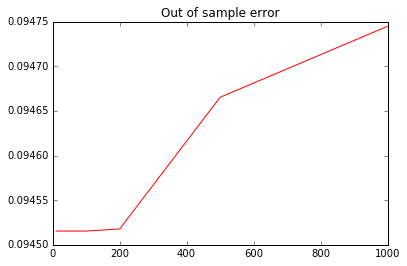

In [47]:
#Graph showing evolution of error on the out_of_sample depending on the range_of_sample
plt.plot(range_of_sample, out_of_sample_error, 'r')
plt.title('Out of sample error')
plt.show()